# Entrenamiento del modelo de predicción de riesgo en código fuente (Laboratorio)

Este notebook demuestra el proceso utilizado para entrenar el modelo machine learning
empleado en el laboratorio de minería de software seguro.

⚠ IMPORTANTE  
Este notebook **no genera el dataset desde cero**, porque eso requiere descargar miles de
archivos mediante scripts específicos del repositorio.

Para obtener el dataset necesario ejecute los scripts del repositorio:

```sh
python src/download_sample.py
```
```sh
python src/extract_features.py
```
Esto generara dos archivos: `/data/meta/dataset_raw.csv` y `/data/meta/dataset_features.csv`.

Este notebook se encarga de:

1. Carga directamente **dataset_features.csv**
2. Realiza preprocesamiento
3. Entrena el modelo Random Forest
4. Evalúa su rendimiento
5. Exporta `best_model.pkl`

Este archivo es suficiente para replicar el modelo utilizado por el sistema real del laboratorio.


### Instalar dependencias

In [ ]:
# Ejecuta solo si estás en Google Colab
%pip install pandas numpy scikit-learn joblib

### Importación de librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib
import matplotlib.pyplot as plt

### Cargar dataset_features.csv

In [22]:
DATASET_PATH = "dataset_features.csv"  # ajustar si está en otra carpeta

try:
    df = pd.read_csv(DATASET_PATH)
    print("Dataset cargado correctamente!")
except FileNotFoundError:
    raise SystemExit("❌ ERROR: No se encontró dataset_features.csv. "
                     "Debes copiarlo al mismo directorio del notebook.")

df.head()

Dataset cargado correctamente!


,loc,comments,functions,classes,imports,ast_nodes,control_structures,cyclomatic_complexity,maintainability_index,repo,file_path,size_bytes
0,138,9,10,0,13,425,17,24,60.237015,scrapy,data/raw\scrapy\conftest.py,4102
1,168,53,0,0,5,301,1,0,89.930148,scrapy,data/raw\scrapy\docs\conf.py,6919
2,34,1,2,0,8,91,1,2,75.443766,scrapy,data/raw\scrapy\docs\conftest.py,955
3,68,12,1,0,3,198,8,7,81.964763,scrapy,data/raw\scrapy\docs\utils\linkfix.py,2043
4,159,3,11,3,8,796,4,23,56.220800,scrapy,data/raw\scrapy\docs\_ext\scrapydocs.py,5051


### Validación del dataset

In [23]:
print("🔍 Verificando si existe la columna 'label'...")

if "label" not in df.columns:
    print("⚠️  No se encontró la columna 'label'. Se generará una etiqueta sintética.")
    
    # Etiquetas aleatorias 0/1 solo para fines de entrenamiento demostrativo
    df["label"] = np.random.randint(0, 2, size=len(df))
    
    print("✔ Columna 'label' generada automáticamente.")
else:
    print("✔ Columna 'label' encontrada en el dataset.")

df.head()

🔍 Verificando si existe la columna 'label'...
⚠️  No se encontró la columna 'label'. Se generará una etiqueta sintética.
✔ Columna 'label' generada automáticamente.


,loc,comments,functions,classes,imports,ast_nodes,control_structures,cyclomatic_complexity,maintainability_index,repo,file_path,size_bytes,label
0,138,9,10,0,13,425,17,24,60.237015,scrapy,data/raw\scrapy\conftest.py,4102,1
1,168,53,0,0,5,301,1,0,89.930148,scrapy,data/raw\scrapy\docs\conf.py,6919,1
2,34,1,2,0,8,91,1,2,75.443766,scrapy,data/raw\scrapy\docs\conftest.py,955,0
3,68,12,1,0,3,198,8,7,81.964763,scrapy,data/raw\scrapy\docs\utils\linkfix.py,2043,0
4,159,3,11,3,8,796,4,23,56.220800,scrapy,data/raw\scrapy\docs\_ext\scrapydocs.py,5051,1


### Selección de características

In [24]:
FEATURES = [
    "loc", "comments", "functions", "classes", "imports",
    "ast_nodes", "control_structures", "cyclomatic_complexity",
    "maintainability_index", "size_bytes"
]

X = df[FEATURES]
y = df["label"]

print("Tamaño del dataset:", X.shape)

Tamaño del dataset: (5298, 10)


### División train / test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((3708, 10), (1590, 10))

### Entrenamiento del modelo Random Forest

In [26]:
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight="balanced",
)

model.fit(X_train, y_train)

print("Modelo entrenado con éxito!")

Modelo entrenado con éxito!


### Evaluación del modelo

In [27]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Matriz de Confusión ===")
print(confusion_matrix(y_test, y_pred))

print("\nROC-AUC:", roc_auc_score(y_test, y_proba))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.50      0.49      0.50       799
           1       0.50      0.51      0.51       791

    accuracy                           0.50      1590
   macro avg       0.50      0.50      0.50      1590
weighted avg       0.50      0.50      0.50      1590


=== Matriz de Confusión ===
[[392 407]
 [385 406]]

ROC-AUC: 0.5071375565854284


### Curva ROC

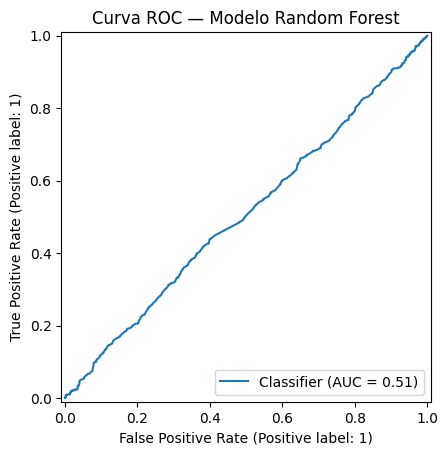

In [28]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Curva ROC — Modelo Random Forest")
plt.show()

### Guardar modelo

In [ ]:
OUTPUT_MODEL = "best_model.pkl"
joblib.dump(model, OUTPUT_MODEL)

print(f"Modelo guardado como {OUTPUT_MODEL}")

# Notas finales

Este notebook genera un modelo basado en las métricas estructurales del código (AST).

El archivo `best_model.pkl` generado aquí se utiliza en el sistema real del laboratorio,
junto con los scripts:

- `analyze_repo.py`
- `predict_risk.py`
- `ci_check.py`

Para que el entrenamiento pueda reproducirse completamente, es necesario generar previamente
el archivo **dataset_features.csv** ejecutando:

```sh
python extract_features.py
```

dentro del repositorio original donde se descargaron los archivos mediante:

```sh
python download_sample.py
```

Este notebook cumple con el propósito de documentar el proceso de entrenamiento del modelo,
de manera independiente y replicable.